# Big Data Module 6 | Analytics & Technology in Oil Trading

##### Based on historical information obtained from JODI (http://www.jodidb.org/TableViewer/tableView.aspx?ReportId=93904) produce an oil analyst forecast for the 2019 Crude Oil Supply Demand Balance of Russia.



**I. Import Libraries**

In [439]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [440]:
import warnings
import itertools
warnings.filterwarnings('ignore')

**II. Dataset retrieving and visualization**

In [441]:
data = pd.read_csv('Module6_Data.csv',index_col='Unnamed: 0',parse_dates=True) # Read the data as a time series
print(data.index) # Make sure the dtype of index is datetime

DatetimeIndex(['2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
               '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01',
               '2002-09-01', '2002-10-01',
               ...
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01'],
              dtype='datetime64[ns]', length=207, freq=None)


In [442]:
# Our dataset is monthly data from Jan-2002 to March-2019
data.head()

,Production,Import,Exports,Refinery
2002-01-01,7000,0,3014,3607
2002-02-01,7093,0,3153,3783
2002-03-01,7142,0,4034,3678
2002-04-01,7135,0,3555,3604
2002-05-01,7214,0,3607,3536


In [443]:
data.tail()

,Production,Import,Exports,Refinery
2018-11-01,10729,0,5664,5922
2018-12-01,10726,0,5529,6033
2019-01-01,10674,0,4983,5959
2019-02-01,10640,0,5412,5965
2019-03-01,10563,0,0,5628


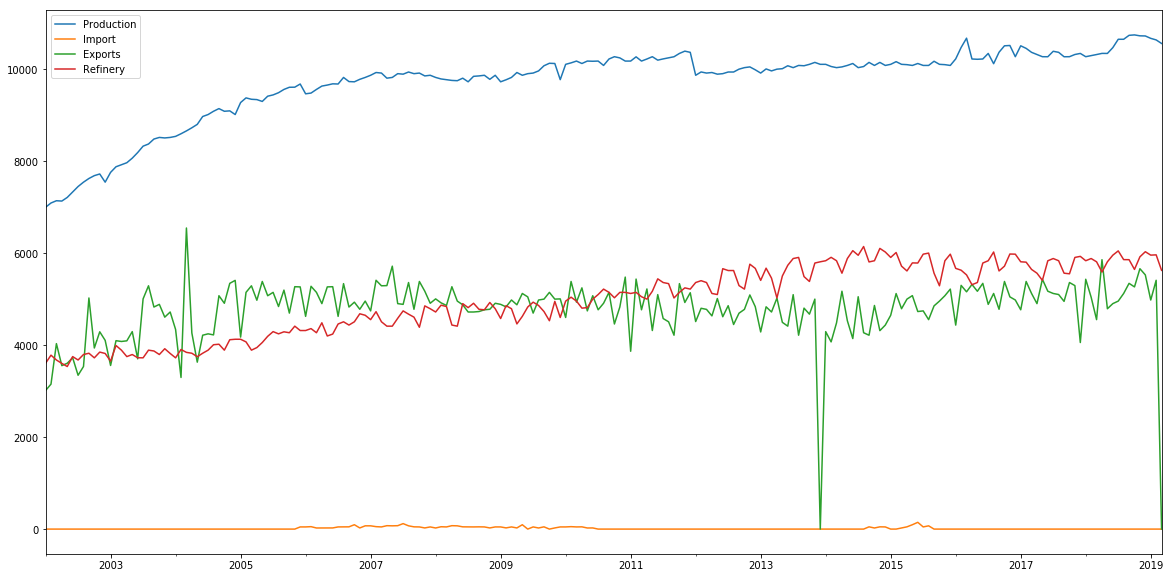

In [444]:
data.plot(figsize=(20,10))

In [445]:
# We noticed there was a sharp drop during 2013 in Exports data
# To find the date of this
export_0_dates = data[data['Exports']==0].index
print(export_0_dates)

# It turned out the Exports data was zero on 2013-12, which we're not sure it is due to data entry error or certain circumstance


DatetimeIndex(['2013-12-01', '2019-03-01'], dtype='datetime64[ns]', freq=None)


**III. Analysis**

We are going to use the historical data from 2002-01 to 2018-12 to predict the data in 2019. 

In [446]:
data_test = data['2002-01-01':'2018-12-01']
data_test.tail()

,Production,Import,Exports,Refinery
2018-08-01,10654,0,5125,5861
2018-09-01,10740,0,5345,5860
2018-10-01,10749,0,5268,5648
2018-11-01,10729,0,5664,5922
2018-12-01,10726,0,5529,6033


And because of the Export data on 2013-12 is zero, which might be caused by error entry. We decide to drop the value of 2013-12-01 from 0 to NaN.

In [447]:
data_test.loc['2013-12-01','Exports'] = None

# Check the data value in 2013-12
data_test.loc['2013-12-01']

Production    10109.0
Import            0.0
Exports           NaN
Refinery       5814.0
Name: 2013-12-01 00:00:00, dtype: float64

In [448]:
data_production = data_test['Production']
data_import = data_test['Import']
data_exports = data_test['Exports'].dropna()
data_refinery = data_test['Refinery']

**(1) Trend and Seasonality**

Statsmodels provides seasonal_decompose function to perform seasonal decomposition out of box. To make it easier to identify trends, seasonality and the structure of our data.

Here, we decompose the series by additive version, which contains three components: a trend, a seasonal component and residuals.

    y = Trend + Seasonal + Residual


In [449]:
from statsmodels.tsa.seasonal import seasonal_decompose

The Production data seems to have upward trend and seasonality

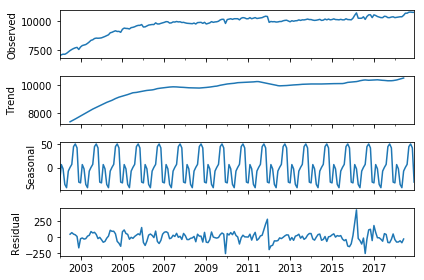

In [450]:
seasonal_decompose(data_production,model='additive',freq=12).plot();

The Import data

We can see the country only imports crude oil in the period of 2005-2011 and 2014-2016

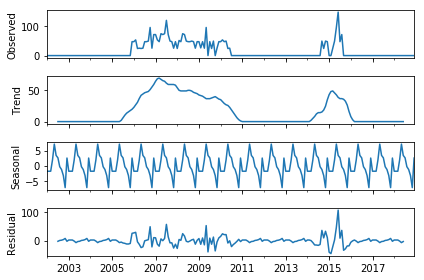

In [451]:
seasonal_decompose(data_import,model='additive',freq=12).plot();

The Exports data

There is no significant trend in the data but we can see certain seasonal effects

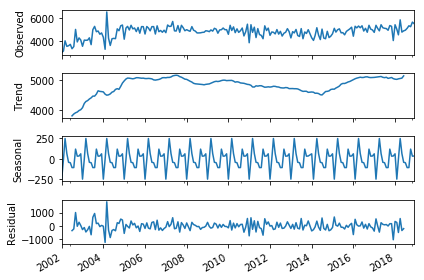

In [452]:
seasonal_decompose(data_exports.dropna(),model='additive',freq=12).plot();

The Refinery data

There is a significant upward trend throughout the periods, but the seasonal effects look a bit of messy.

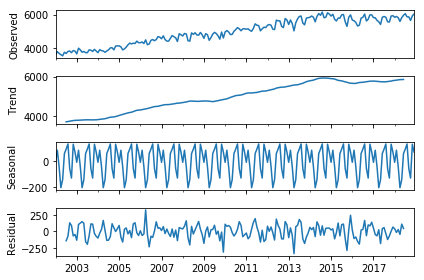

In [453]:
seasonal_decompose(data_refinery,model='additive',freq=12).plot();

**(2) Test Stationary**

Stationarity is the property of exhibiting constant statistical properties (mean, variance, autocorrelation, etc.)

We need to test time series' staionarity because most of the time series models work on the assumption of the series is stationary.

There are two ways to check stationarity:
1. Plotting Rolling Statistics
2. Dicky-Fuller Test

For Dicky-Fuller Test, if the 'Test Statistic' is less than the 'Critical Value'(or, the p-value is less than Critical Value(1%,5%,10%), we can reject the null hypothesis and say the series is stationary.

In [454]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [455]:
def test_stationarity(timeseries):
    
    #Rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot
    plt.figure(figsize=(20,6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dicky-Fuller Test
    print('Results of Dickey-Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s) '%key] = value
    print(dfoutput)

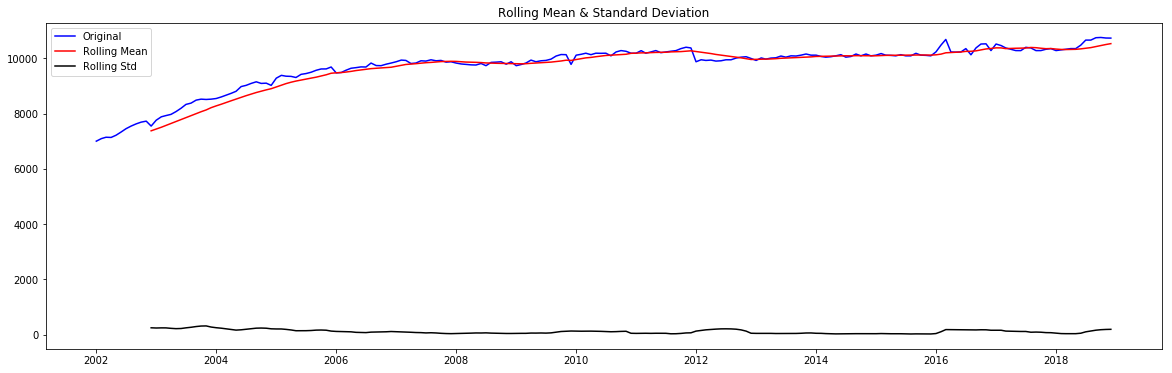

Results of Dickey-Fuller Test
Test Statistic                  -4.824535
p-value                          0.000049
#Lags Used                       5.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64


In [456]:
# Production data is stationary
test_stationarity(data_production)

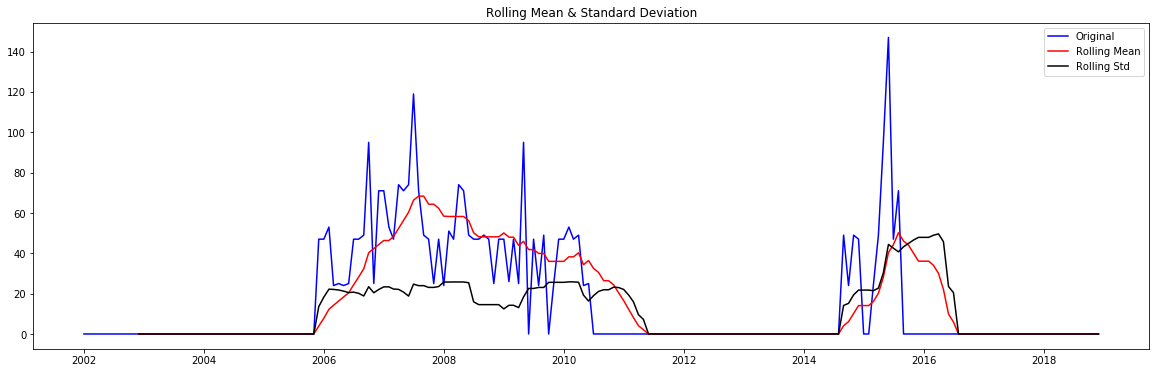

Results of Dickey-Fuller Test
Test Statistic                  -1.946962
p-value                          0.310301
#Lags Used                       6.000000
Number of Observations Used    197.000000
Critical Value (1%)             -3.463987
Critical Value (5%)             -2.876326
Critical Value (10%)            -2.574652
dtype: float64


In [457]:
# Import data is non-stationary
test_stationarity(data_import)

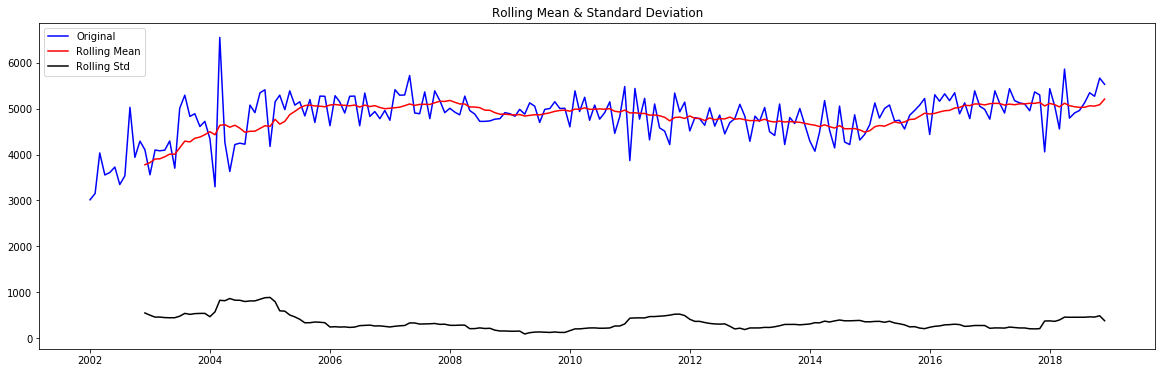

Results of Dickey-Fuller Test
Test Statistic                  -3.009348
p-value                          0.034031
#Lags Used                      11.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


In [458]:
# Exports data is stationary at 5% significant level
test_stationarity(data_exports)

**(3) Autocorrelation plots (ACF & PACF)**

Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

The plots can be used to determine the parameters (p,d,q) in ARIMA model. However, we will use grid search instead, which will be explained further below.

In [459]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

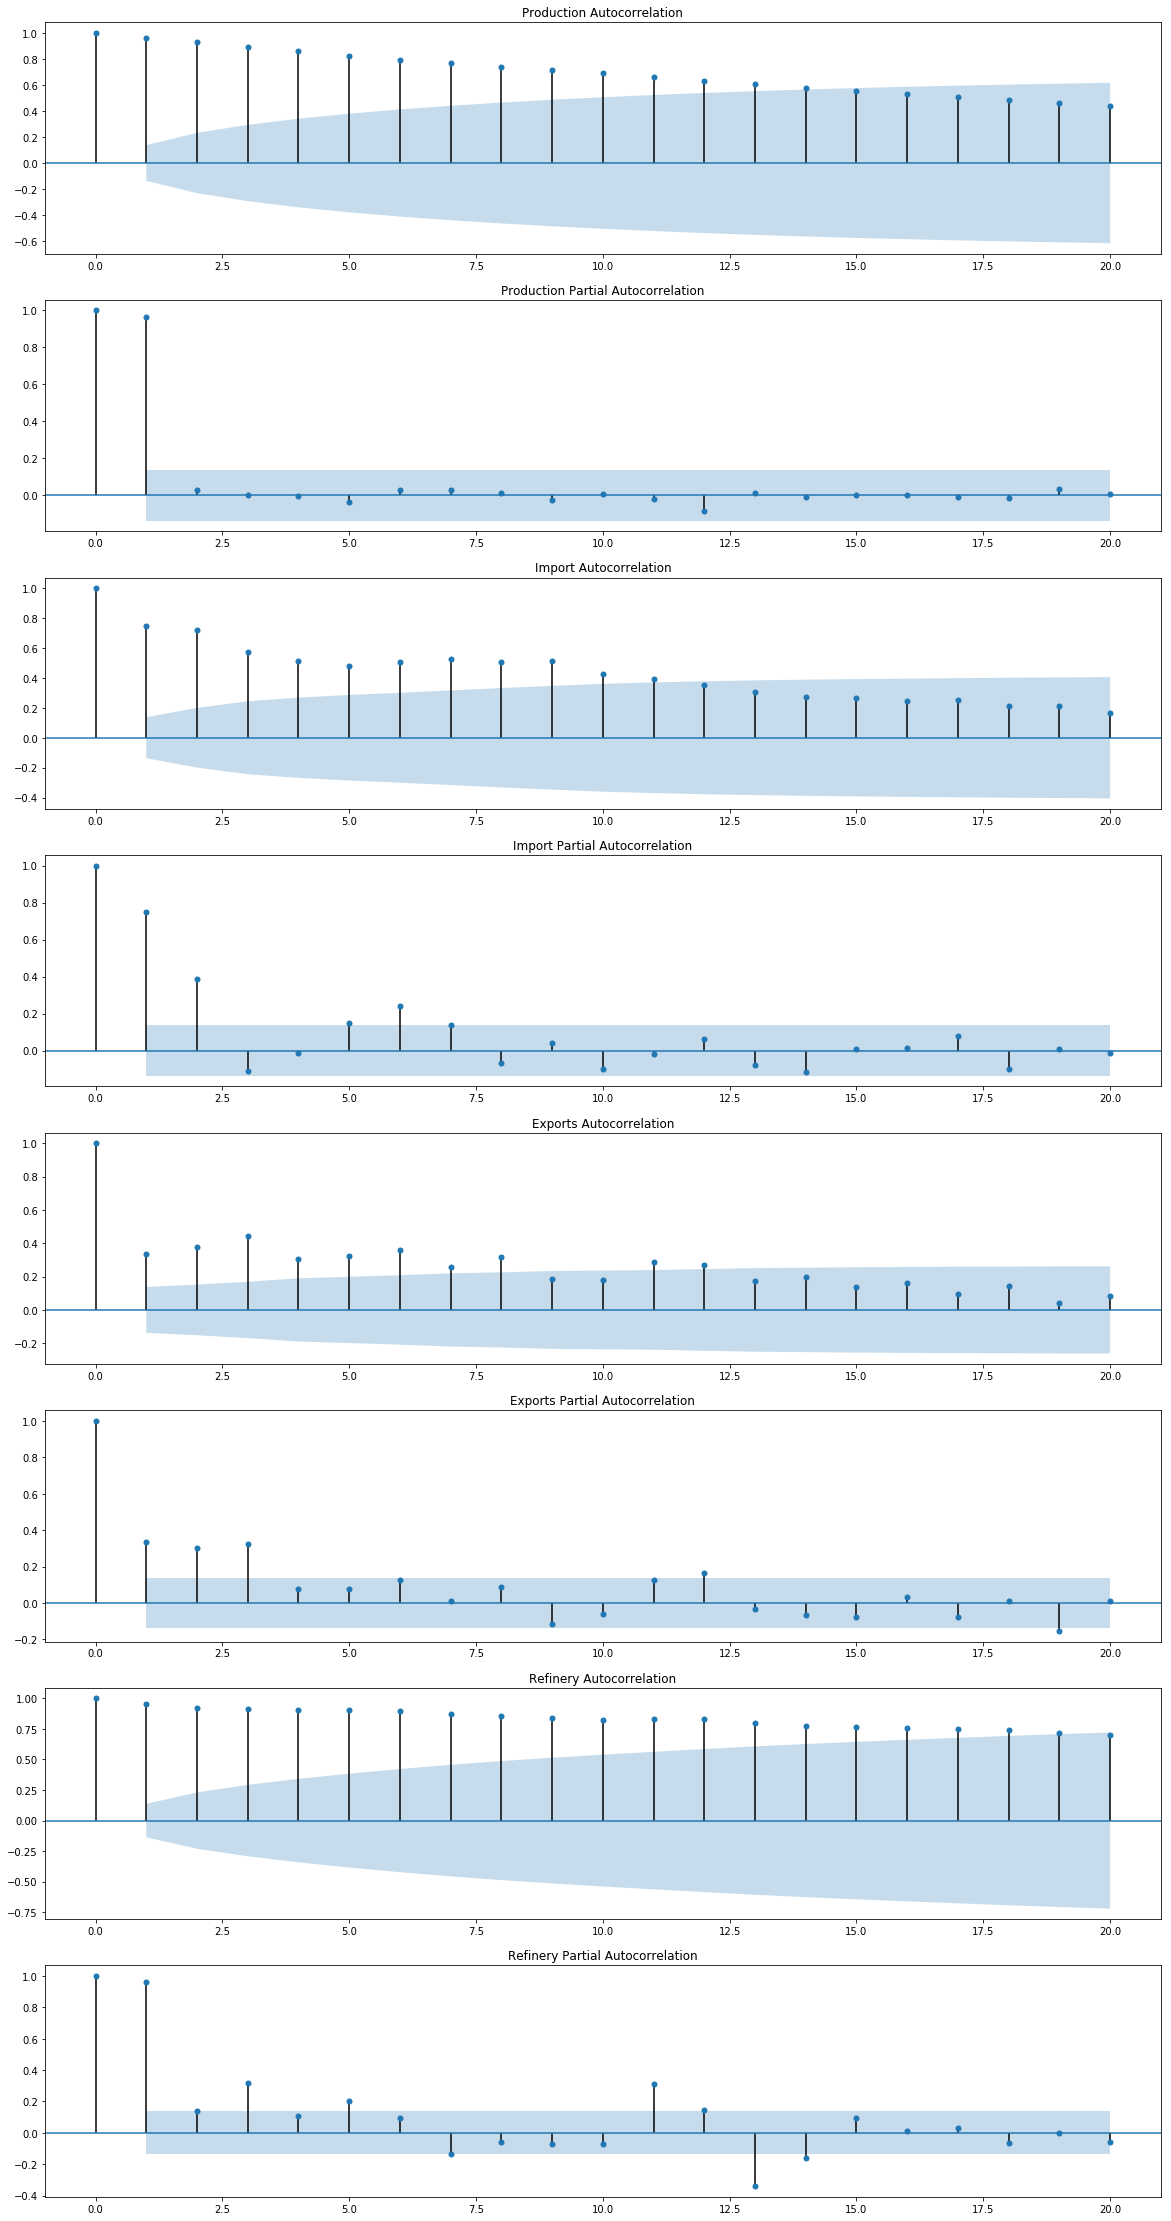

In [460]:
fig, ax = plt.subplots(8, figsize=(20,40))

# Production
ax[0] = plot_acf(data_production, ax=ax[0], lags=20, title='Production Autocorrelation')
ax[1] = plot_pacf(data_production, ax=ax[1], lags=20, title='Production Partial Autocorrelation')

# Import
ax[2] = plot_acf(data_import, ax=ax[2], lags=20, title='Import Autocorrelation')
ax[3] = plot_pacf(data_import, ax=ax[3], lags=20, title='Import Partial Autocorrelation')

# Exports
ax[4] = plot_acf(data_exports, ax=ax[4], lags=20, title='Exports Autocorrelation')
ax[5] = plot_pacf(data_exports, ax=ax[5], lags=20, title='Exports Partial Autocorrelation')

# Refinery
ax[6] = plot_acf(data_refinery, ax=ax[6], lags=20, title='Refinery Autocorrelation')
ax[7] = plot_pacf(data_refinery, ax=ax[7], lags=20, title='Refinery Partial Autocorrelation')


**IV. Seasonal ARIMA Model**

ARIMA (Auto-Regressive Integrated Moving Averages) model can be used to forecasts a stationary time series.
Seasonal ARIMA, an extension of ARIMA that explicitly supports unvariate time series with a seasonal component. 

- Trend Elements
    
    p: trend autoregression order
    
    d: trend difference order
    
    q: trend moving average order
    
    Trend elements can be chosen through analysis of ACF and PACF plots looking at the correlations of recent time steps
    
    
- Seasonal Elements
    
    P: Seasonal autoregressive order
    
    D: Seasonal difference order
    
    Q: Seasonal moving average order
    
    m: the number of time steps for a single seasonal period
    
    Similarly, ACF and PACF plots can be analysed to specify values for the seasonal model by looking at correlation at seasonal lag time steps
    
SARIMA(p,d,q)(P,D,Q)m
eg. m=12 for monthly data suggests a yearly seasonal cycle
    D=1 would calculate a first order seasonal difference 
    Q=1 would use first order errors in the model (eg. moving average)

**(1) Grid Search**

To find the optimal parameters for SARIMA model

In [461]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q)) 
# Generate all different combinations of p,d,q

pdq_x_PDQs = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]
# Generate all different combinations of seasonal p,d and q triplets

print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1],pdq_x_PDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2],pdq_x_PDQs[2]))

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)


Use the AIC (Akaike Information Criterion) value to measure how well a model fits the data.
Find the model that yields the lowest AIC value

Production
    
    We noted from below result that the best AIC found is 2145.335, which corresponds to the parameters of ARIMA(1, 0, 1)x(0, 1, 1, 12)

In [462]:
aic_results = []
for param in pdq:
    for seasonal_param in pdq_x_PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_production,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,seasonal_param,results.aic))
            if results.mle_retvals is not None and results.mle_retvals['converged'] == False:
                print(results.mle_retvals)
            aic_results.append(results.aic)
        
        except:
            continue

aic_results.sort()
print('BEST AIC Found:', aic_results[0])

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:4307.493262299666
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:4063.7811615820224
{'fopt': 9.95044402348535, 'gopt': array([ 9.26595689e-05, -2.19393019e-03]), 'fcalls': 228, 'warnflag': 1, 'converged': False, 'iterations': 50}
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:2787.904937557395
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2494.6264866876354
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:2755.816092615573
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:2705.351013829938
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:2476.7050366274534
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:2373.65841610713
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:4141.270655648659
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:5435.896427092104
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:2614.7413414631874
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:2383.4683936703386
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:2611.4683651300147
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:2557.3490584569936
{'fopt': 6.248404555041651, 'gopt': array([-2.16315854e-06, -7.47573559e-05, -1.43740131e-05,  2.31814568e

Import

    We noted from below result that the best AIC found is 1557.334, which corresponds to the parameters of ARIMA(0, 1, 1)x(0, 1, 1, 12)

In [463]:
aic_results = []
for param in pdq:
    for seasonal_param in pdq_x_PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_import,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,seasonal_param,results.aic))
            if results.mle_retvals is not None and results.mle_retvals['converged'] == False:
                print(results.mle_retvals)
            aic_results.append(results.aic)
        
        except:
            continue

aic_results.sort()
print('BEST AIC Found:', aic_results[0])

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1973.2853945137408
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1827.8494445288297
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1856.2988150424849
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1729.7336991270286
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1815.6572701801954
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1808.1562279584195
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1744.8151628868522
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1717.0561322885073
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1872.3978774256327
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:1755.7315297496752
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:1806.8943961733858
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:1660.0453240796992
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1760.8654172819934
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1743.9502661875163
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:1694.1046982510243
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:1656.4794682086758
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:1767.9597986424596
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1676.6792067820886
ARIMA(0, 1, 0)x(0, 1, 0, 12)

Exports

    We noted from below result that the best AIC found is 2605.375, which corresponds to the parameters of ARIMA(1, 1, 1)x(0, 1, 1, 12)

In [464]:
aic_results = []
for param in pdq:
    for seasonal_param in pdq_x_PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_exports,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,seasonal_param,results.aic))
            if results.mle_retvals is not None and results.mle_retvals['converged'] == False:
                print(results.mle_retvals)
            aic_results.append(results.aic)
        
        except:
            continue

aic_results.sort()
print('BEST AIC Found:', aic_results[0])

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:4003.6238930493746
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:3643.8826678449946
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:2936.170576590912
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2706.8733100888708
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:2951.8772860735007
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:2926.3675998555154
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:2722.768035339602
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:2676.448817950401
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:3849.3445824704386
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:3384.318296910921
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:2920.6240906704184
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:2692.266789418784
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:2953.7746352364347
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:2922.24155503529
{'fopt': 7.1779348646189405, 'gopt': array([-2.53418678e-02, -3.43186744e-01,  3.03146132e-02, -2.63976041e-04]), 'fcalls': 400, 'warnflag': 1, 'converged': False, 'iterations': 50}
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:2724.617720283796
ARIMA(0, 0, 1)x(

Refinery

        We noted from below result that the best AIC found is 2231.961, which corresponds to the parameters of ARIMA(1, 1, 1)x(0, 1, 1, 12)

In [465]:
aic_results = []
for param in pdq:
    for seasonal_param in pdq_x_PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_refinery,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,seasonal_param,results.aic))
            if results.mle_retvals is not None and results.mle_retvals['converged'] == False:
                print(results.mle_retvals)
            aic_results.append(results.aic)
        
        except:
            continue

aic_results.sort()
print('BEST AIC Found:', aic_results[0])

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:4038.3700060171745
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:3684.0732513823586
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:2624.823448981131
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2465.9179824708262
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:2575.501539800137
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:2562.173566379264
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:2475.958496339474
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:2410.472216020083
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:3874.0799602324873
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:3321.2536601898655
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:2543.5259852450736
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:2393.1690121962893
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:2585.231187411334
{'fopt': 6.321645067184642, 'gopt': array([0.00242673, 0.37083128, 0.00870057]), 'fcalls': 324, 'warnflag': 1, 'converged': False, 'iterations': 50}
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:2495.501242716584
{'fopt': 6.0968167713641765, 'gopt': array([ 7.19630577e-05, -1.64860143e-03,  3.35950823e-05, -2.0504

**(2) Modeling**

Production

In [466]:
mod_p = sm.tsa.statespace.SARIMAX(data_production, 
                                order=(1,0,1), 
                                seasonal_order=(0,1,1,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_p = mod_p.fit()
print(results_p.summary())


                                 Statespace Model Results                                 
Dep. Variable:                         Production   No. Observations:                  204
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1068.668
Date:                            Fri, 28 Jun 2019   AIC                           2145.335
Time:                                    01:19:52   BIC                           2158.062
Sample:                                01-01-2002   HQIC                          2150.496
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9719      0.007    142.606      0.000       0.959       0.985
ma.L1         -0.3058      0.047   

The diagonostics below helps us to ensure the residuals in our model are uncorrelated and normally distributed with zero mean. If our SARIMA model does not satisfy these properties, meaning the model needs further improved.

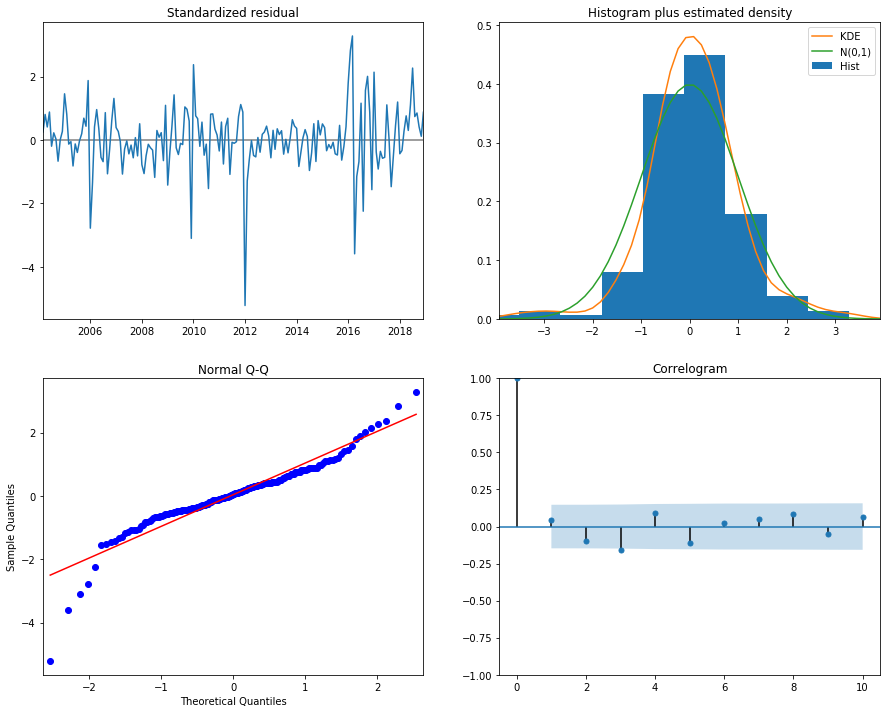

In [467]:
results_p.plot_diagnostics(figsize=(15,12))
plt.show()

Import

In [468]:
mod_i = sm.tsa.statespace.SARIMAX(data_import, 
                                order=(0,1,1), 
                                seasonal_order=(0,1,1,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_i = mod_i.fit()
print(results_i.summary())


                                 Statespace Model Results                                 
Dep. Variable:                             Import   No. Observations:                  204
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -775.667
Date:                            Fri, 28 Jun 2019   AIC                           1557.334
Time:                                    01:19:53   BIC                           1566.863
Sample:                                01-01-2002   HQIC                          1561.199
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4697      0.030    -15.580      0.000      -0.529      -0.411
ma.S.L12      -1.0000   1018.260   

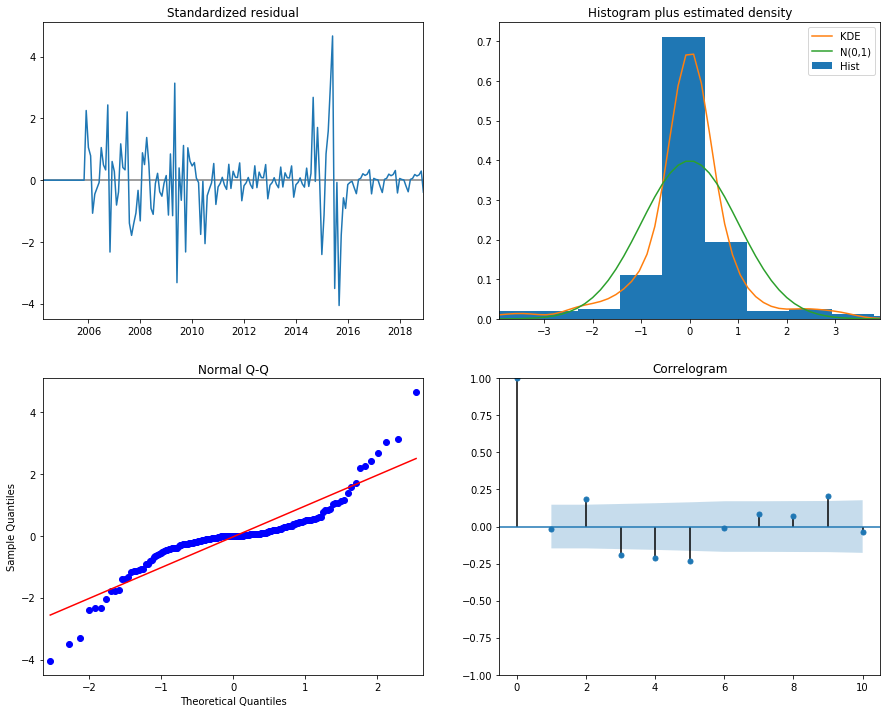

In [469]:
results_i.plot_diagnostics(figsize=(15,12))
plt.show()

Exports

In [470]:
mod_e = sm.tsa.statespace.SARIMAX(data_test['Exports'], 
                                order=(1,1,1), 
                                seasonal_order=(0,1,1,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_e = mod_e.fit()
print(results_e.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            Exports   No. Observations:                  204
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1295.700
Date:                            Fri, 28 Jun 2019   AIC                           2599.400
Time:                                    01:19:54   BIC                           2612.104
Sample:                                01-01-2002   HQIC                          2604.552
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2331      0.080     -2.898      0.004      -0.391      -0.075
ma.L1         -0.7270      0.064   

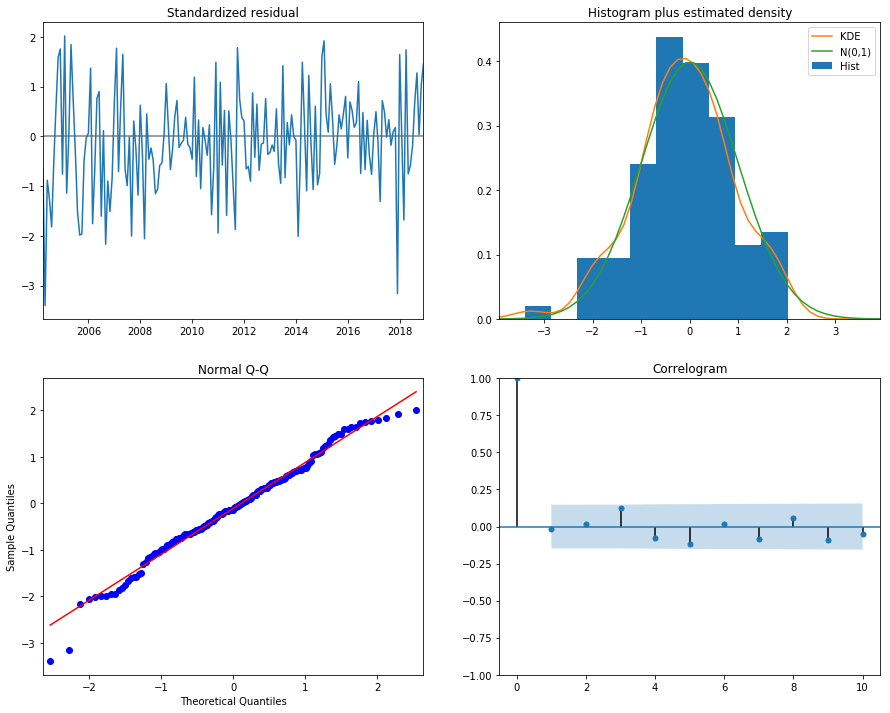

In [471]:
results_e.plot_diagnostics(figsize=(15,12))
plt.show()

Refinery

In [472]:
mod_r = sm.tsa.statespace.SARIMAX(data_refinery, 
                                order=(1,1,1), 
                                seasonal_order=(0,1,1,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_r = mod_r.fit()
print(results_r.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           Refinery   No. Observations:                  204
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1111.981
Date:                            Fri, 28 Jun 2019   AIC                           2231.962
Time:                                    01:19:55   BIC                           2244.666
Sample:                                01-01-2002   HQIC                          2237.114
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1653      0.121      1.367      0.172      -0.072       0.402
ma.L1         -0.7307      0.079   

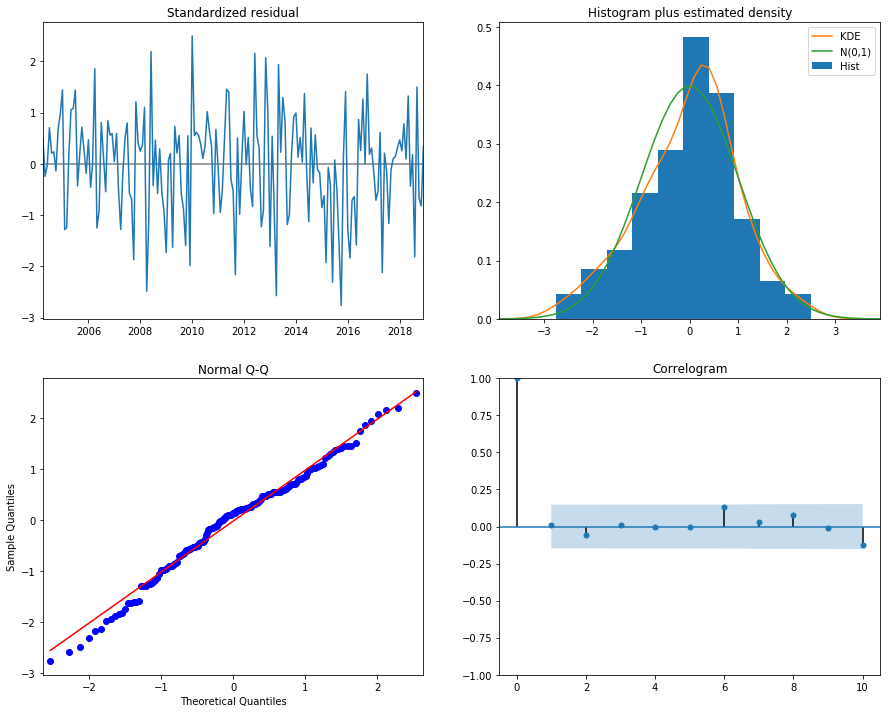

In [473]:
results_r.plot_diagnostics(figsize=(15,12))
plt.show()

**(3) Validating Prediction**

We use prediction function in order to see how well our model performs within the sample.
We use Dynamic Forecast, which means the forecasts at each point are generated using the full history up to that point

In [474]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2002-01-01 to 2018-12-01
Data columns (total 4 columns):
Production    204 non-null int64
Import        204 non-null int64
Exports       203 non-null float64
Refinery      204 non-null int64
dtypes: float64(1), int64(3)
memory usage: 18.0 KB


Production

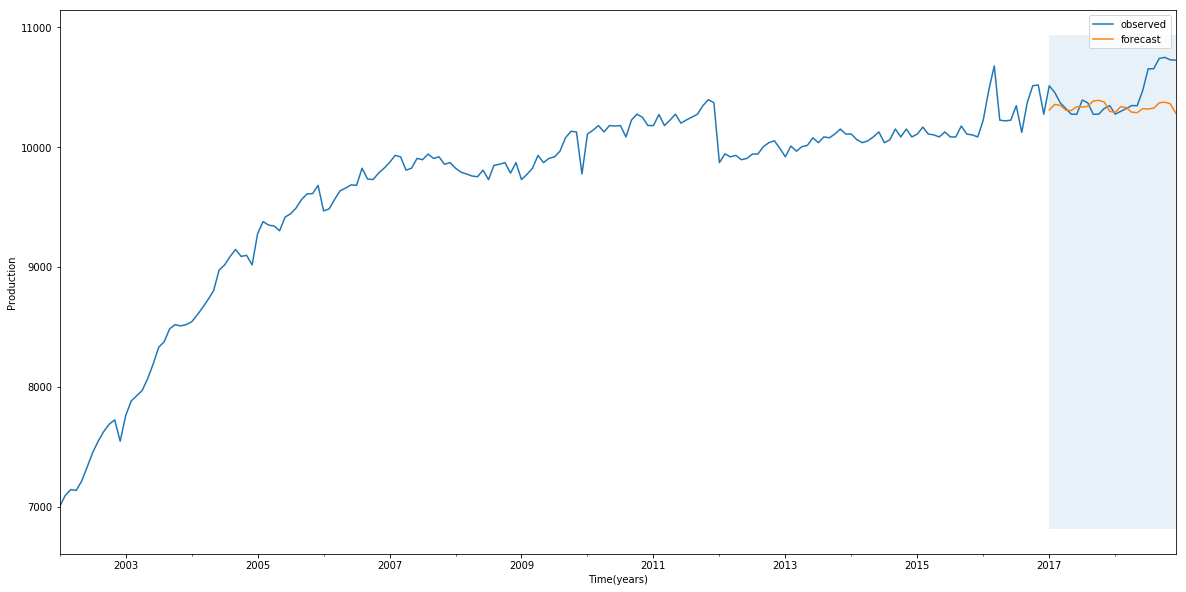

In [475]:
pred_p = results_p.get_prediction(start=pd.to_datetime('2017-01-01'),end=pd.to_datetime('2018-12-01'),dynamic=True,full_results=True)
pred_p_ci = pred_p.conf_int()

ax = data_production.plot(label='observed',figsize=(20,10))
pred_p.predicted_mean.plot(label='forecast',ax=ax)

ax.fill_betweenx(ax.get_ylim(),
                pd.to_datetime('2017-01-01'),
                data_production.index[-1],
                alpha=.1,
                zorder=-1)

ax.set_xlabel('Time(years)')
ax.set_ylabel('Production')
plt.legend()

Import

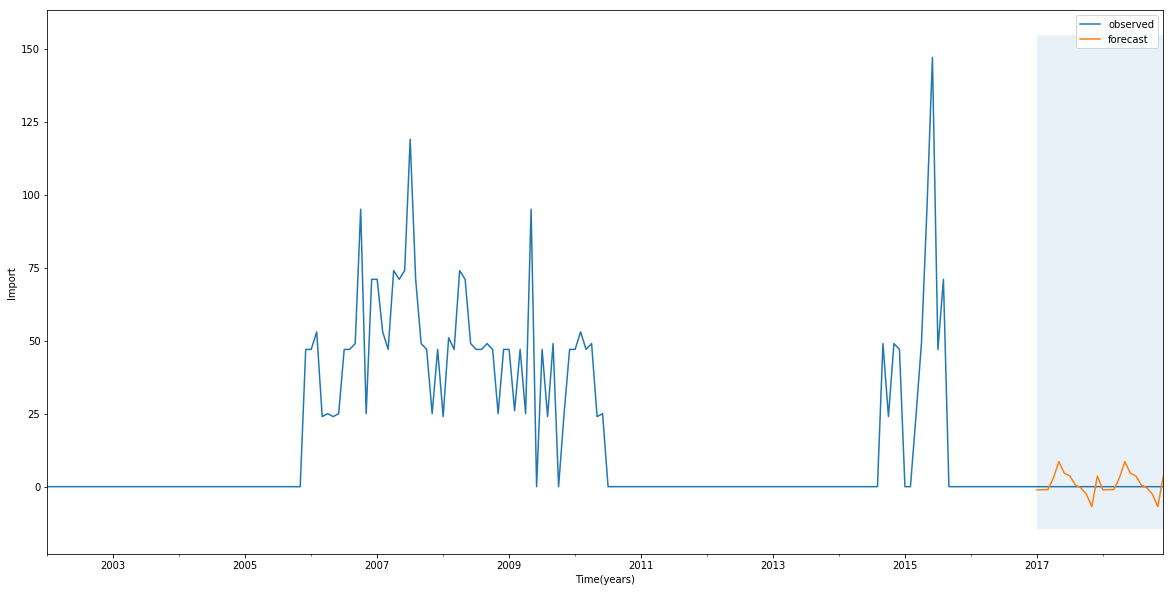

In [476]:
pred_i = results_i.get_prediction(start=pd.to_datetime('2017-01-01'),end=pd.to_datetime('2018-12-01'),dynamic=True,full_results=True)
pred_i_ci = pred_i.conf_int()

ax = data_import.plot(label='observed',figsize=(20,10))
pred_i.predicted_mean.plot(label='forecast',ax=ax)

ax.fill_betweenx(ax.get_ylim(),
                pd.to_datetime('2017-01-01'),
                data_import.index[-1],
                alpha=.1,
                zorder=-1)

ax.set_xlabel('Time(years)')
ax.set_ylabel('Import')
plt.legend()

Exports

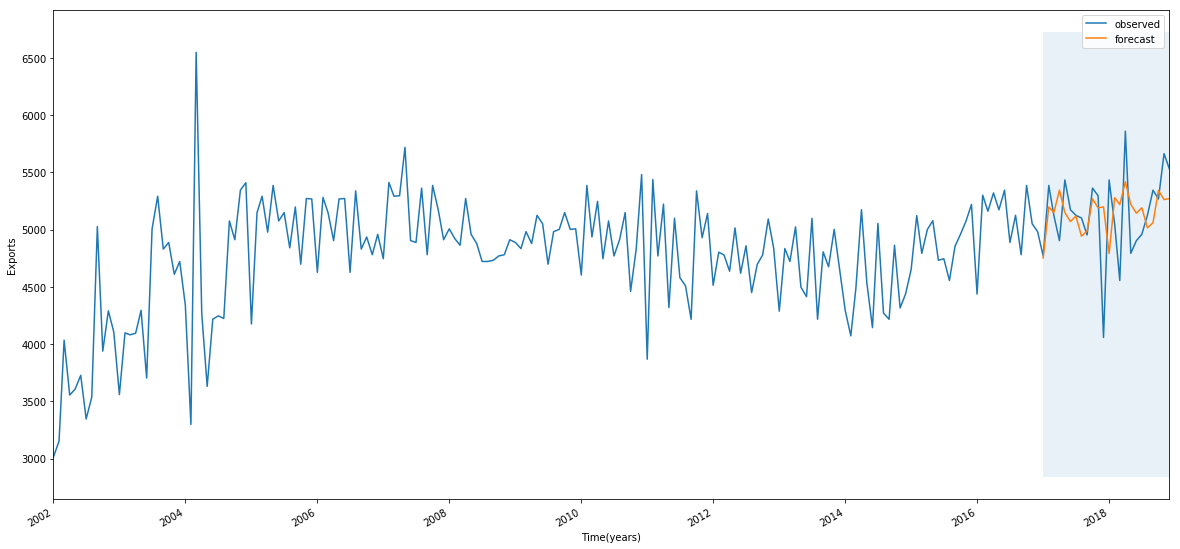

In [477]:
pred_e = results_e.get_prediction(start=pd.to_datetime('2017-01-01'),end=pd.to_datetime('2018-12-01'),dynamic=True,full_results=True)
pred_e_ci = pred_e.conf_int()

ax = data_exports.plot(label='observed',figsize=(20,10))
pred_e.predicted_mean.plot(label='forecast',ax=ax)

ax.fill_betweenx(ax.get_ylim(),
                pd.to_datetime('2017-01-01'),
                data_exports.index[-1],
                alpha=.1,
                zorder=-1)

ax.set_xlabel('Time(years)')
ax.set_ylabel('Exports')
plt.legend()

Refinery

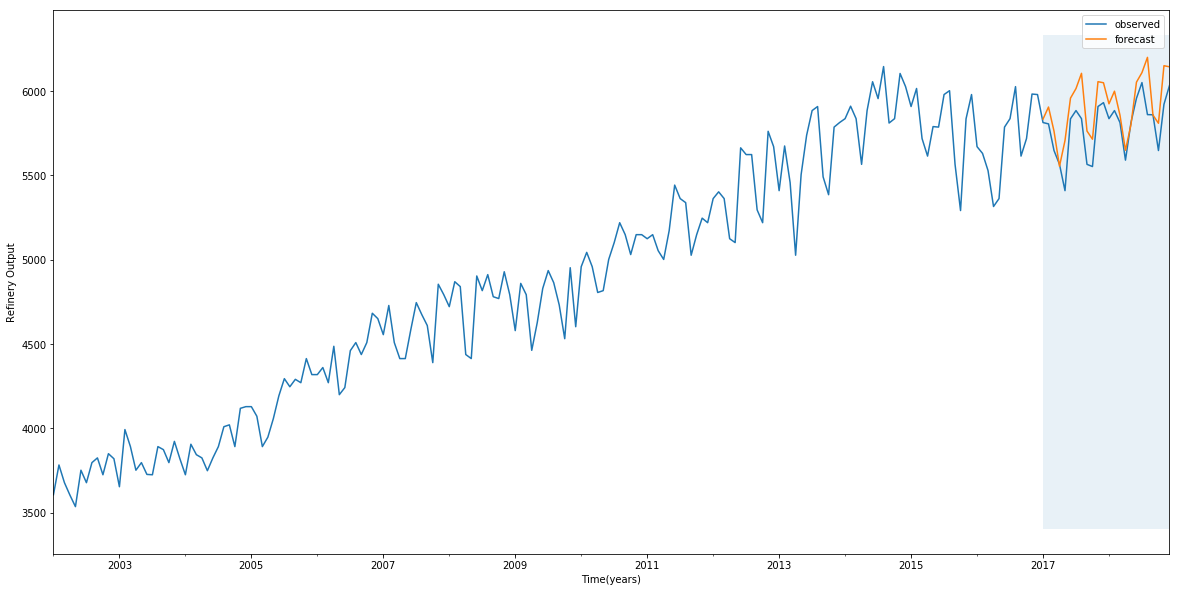

In [478]:
pred_r = results_r.get_prediction(start=pd.to_datetime('2017-01-01'),end=pd.to_datetime('2018-12-01'),dynamic=True,full_results=True)
pred_r_ci = pred_r.conf_int()

ax = data_refinery.plot(label='observed',figsize=(20,10))
pred_r.predicted_mean.plot(label='forecast',ax=ax)

ax.fill_betweenx(ax.get_ylim(),
                pd.to_datetime('2017-01-01'),
                data_refinery.index[-1],
                alpha=.1,
                zorder=-1)

ax.set_xlabel('Time(years)')
ax.set_ylabel('Refinery Output')
plt.legend()

**V. Forecasting**

Production

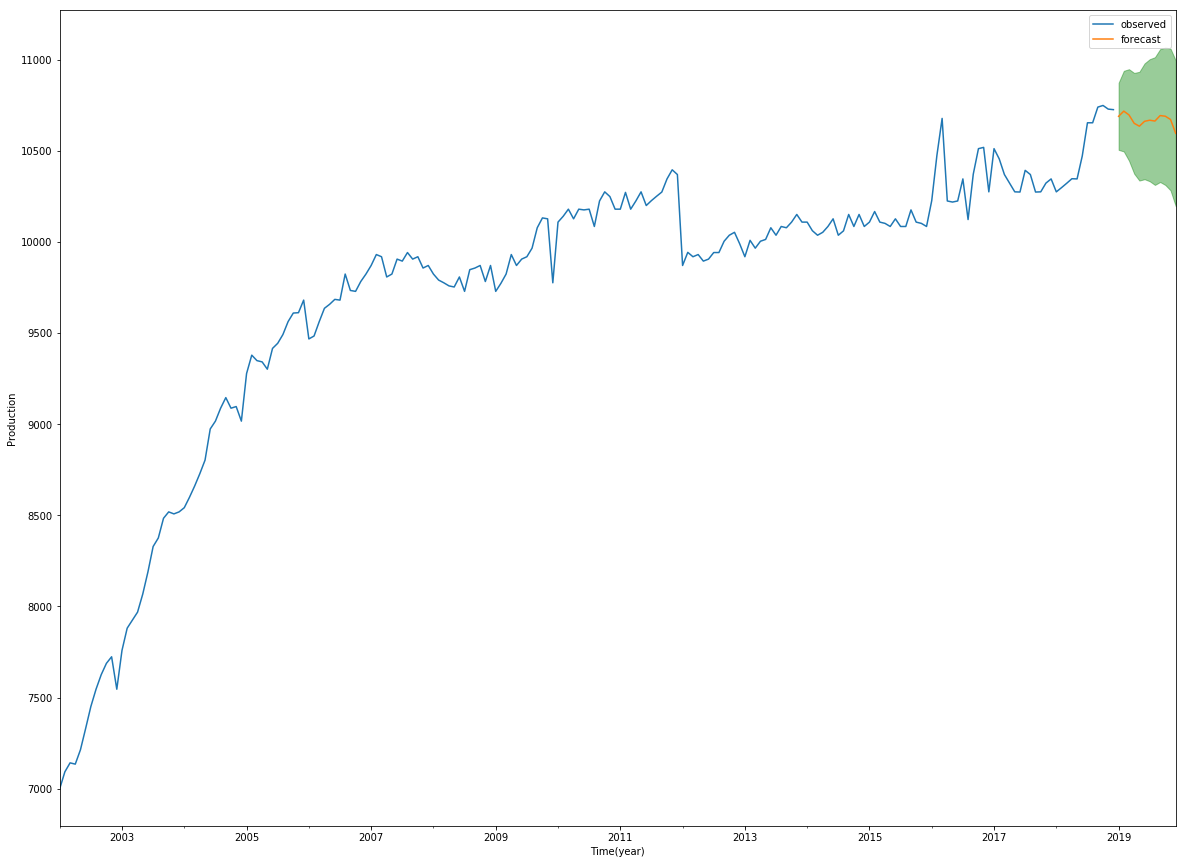

In [479]:
forecast_p = results_p.get_forecast(steps=12)
forecast_p_ci = forecast_p.conf_int()

ax = data_production.plot(label='observed',figsize=(20,15))
forecast_p.predicted_mean.plot(ax=ax,label='forecast')
ax.fill_between(forecast_p_ci.index,
               forecast_p_ci.iloc[:,0],
               forecast_p_ci.iloc[:,1],
               color='g',alpha=.4)
ax.set_xlabel('Time(year)')
ax.set_ylabel('Production')

plt.legend()
plt.show()

Import

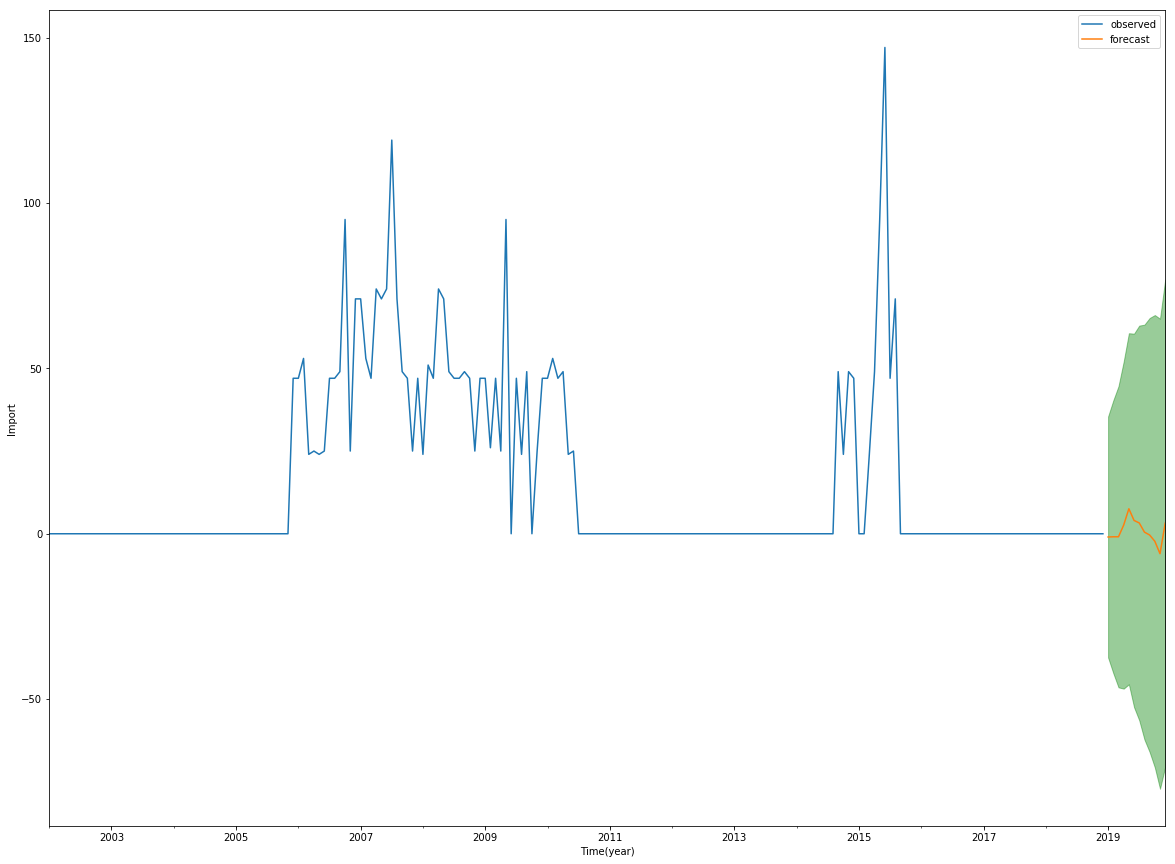

In [480]:
forecast_i = results_i.get_forecast(steps=12)
forecast_i_ci = forecast_i.conf_int()

ax = data_import.plot(label='observed',figsize=(20,15))
forecast_i.predicted_mean.plot(ax=ax,label='forecast')
ax.fill_between(forecast_i_ci.index,
               forecast_i_ci.iloc[:,0],
               forecast_i_ci.iloc[:,1],
               color='g',alpha=.4)
ax.set_xlabel('Time(year)')
ax.set_ylabel('Import')

plt.legend()
plt.show()

Exports

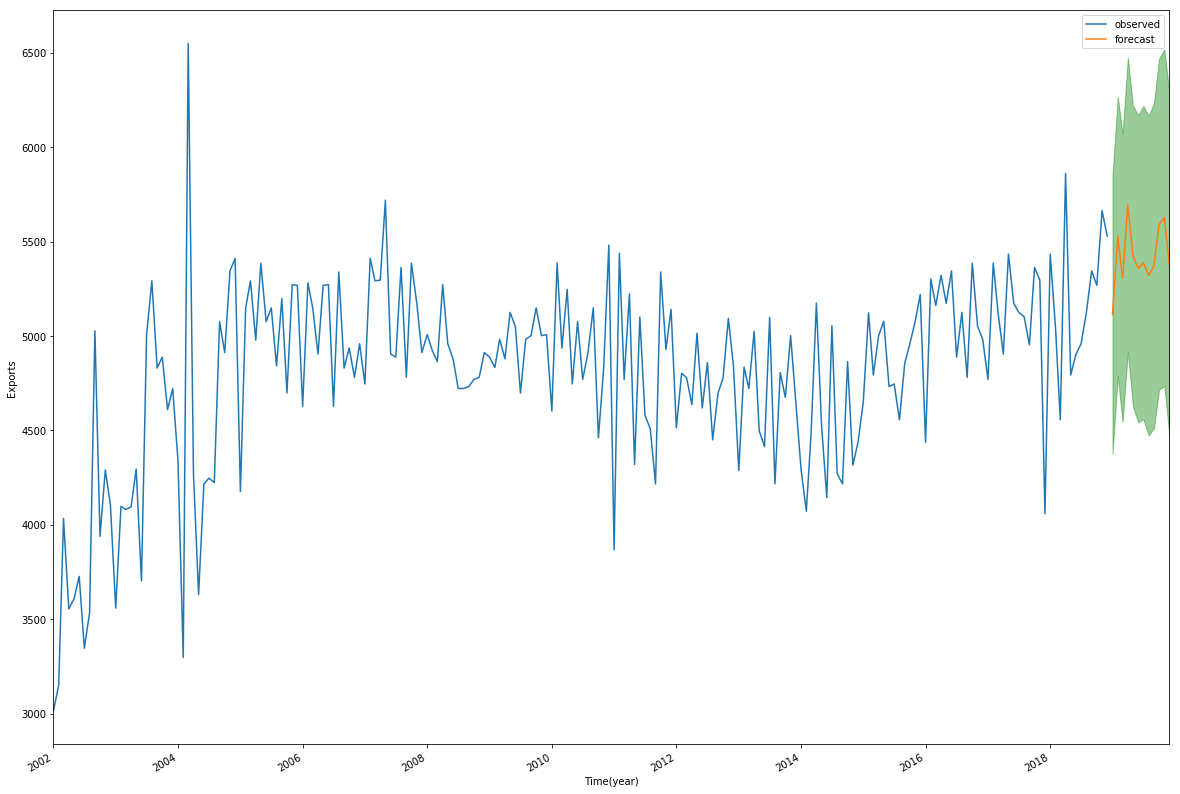

In [481]:
forecast_e = results_e.get_forecast(steps=12)
forecast_e_ci = forecast_e.conf_int()

ax = data_exports.plot(label='observed',figsize=(20,15))
forecast_e.predicted_mean.plot(ax=ax,label='forecast')

ax.fill_between(forecast_e_ci.index,
               forecast_e_ci.iloc[:,0],
               forecast_e_ci.iloc[:,1],
               color='g',alpha=.4)
ax.set_xlabel('Time(year)')
ax.set_ylabel('Exports')

plt.legend()
plt.show()


Refinery

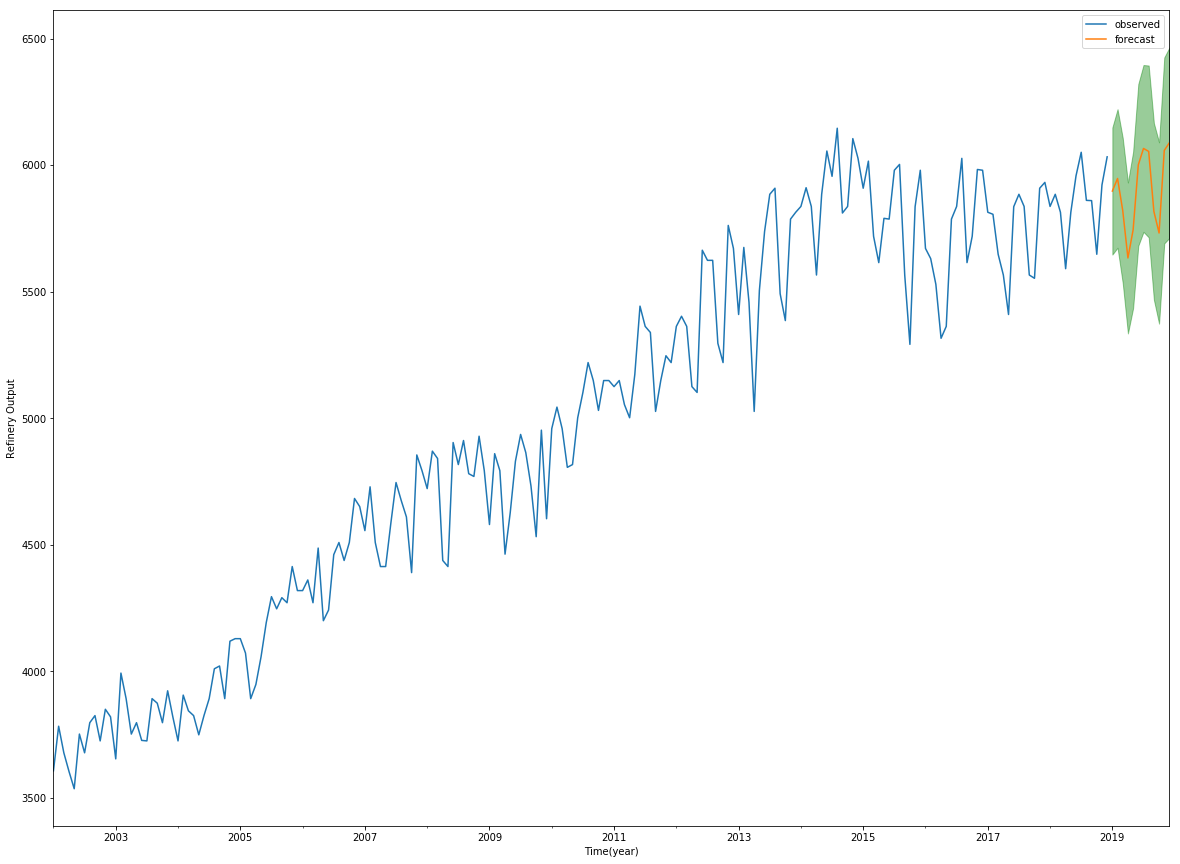

In [482]:
forecast_r = results_r.get_forecast(steps=12)
forecast_r_ci = forecast_r.conf_int()

ax = data_refinery.plot(label='observed',figsize=(20,15))
forecast_r.predicted_mean.plot(ax=ax,label='forecast')
ax.fill_between(forecast_r_ci.index,
               forecast_r_ci.iloc[:,0],
               forecast_r_ci.iloc[:,1],
               color='g',alpha=.4)
ax.set_xlabel('Time(year)')
ax.set_ylabel('Refinery Output')

plt.legend()
plt.show()

**VI. Output**

In [483]:
from pandas.tseries.offsets import DateOffset

(1) Create future dates 2019-01-01 to 2019-12-01

In [484]:
future_dates = [data_test.index[-1] + DateOffset(months=x) for x in range(0,13)]
future_dates

[Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-12-01 00:00:00')]

In [485]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=data.columns)
future_dates_df.head()

,Production,Import,Exports,Refinery
2019-01-01,NaN,NaN,NaN,NaN
2019-02-01,NaN,NaN,NaN,NaN
2019-03-01,NaN,NaN,NaN,NaN
2019-04-01,NaN,NaN,NaN,NaN
2019-05-01,NaN,NaN,NaN,NaN


In [486]:
data_future = pd.concat([data_test,future_dates_df])

In [487]:
data_future.head()

,Production,Import,Exports,Refinery
2002-01-01,7000,0,3014.0,3607
2002-02-01,7093,0,3153.0,3783
2002-03-01,7142,0,4034.0,3678
2002-04-01,7135,0,3555.0,3604
2002-05-01,7214,0,3607.0,3536


In [488]:
data_future.tail()

,Production,Import,Exports,Refinery
2019-08-01,NaN,NaN,NaN,NaN
2019-09-01,NaN,NaN,NaN,NaN
2019-10-01,NaN,NaN,NaN,NaN
2019-11-01,NaN,NaN,NaN,NaN
2019-12-01,NaN,NaN,NaN,NaN


In [489]:
data_future['Production_Forecast'] = forecast_p.predicted_mean
data_future['Import_Forecast'] = forecast_i.predicted_mean
data_future['Exports_Forecast'] = forecast_e.predicted_mean
data_future['Refinery_Forecast'] = forecast_r.predicted_mean

In [490]:
data_future.tail()

,Production,Import,Exports,Refinery,Production_Forecast,Import_Forecast,Exports_Forecast,Refinery_Forecast
2019-08-01,NaN,NaN,NaN,NaN,10663.411582,0.498567,5320.094159,6054.367535
2019-09-01,NaN,NaN,NaN,NaN,10693.519916,-0.383796,5371.207153,5817.412899
2019-10-01,NaN,NaN,NaN,NaN,10689.959604,-2.266148,5591.977476,5732.075694
2019-11-01,NaN,NaN,NaN,NaN,10672.197536,-6.030777,5625.860018,6058.265515
2019-12-01,NaN,NaN,NaN,NaN,10596.155235,3.204370,5374.036619,6089.024201


In [491]:
data_future.to_csv('data_future_2.csv')